# Introduction

* Testing 1D ML-URANS model with ODE solver and comparing with true data
* **NOTE**: For modeling energies

In [1]:
# import all python, pytorch, and ML libraries, classes and functions
from NN_funcs import *

# for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Start main

## Set parameters

In [2]:
# Data type
casenum       = [1]       # dataset case number(s) (see DataAcqu_LSTM.ipynb or data_funcs.py)
casenum_test  = [1]          # case to be tested
# parameters used for data acquisition
target_T        = 1          # target time period for sampling frequency
seq_len_T       = 64         # target sequence length (sampling frequency) of LSTM input for target_T
dt_target       = target_T/seq_len_T

normEnergy    = True         # normalize energy
interpIO      = True         # interpolate data
set_dt_seq    = True         # set dt for `interpIO` such that time length of `seq_len` data points = 1 time period
dt_T          = 1.0          # dt for interpIO
if set_dt_seq:
    seq_len     = int(dt_T/dt_target)  # sequence length (lag time) for LSTM input
else:
    seq_len     = seq_len_T            # sequence length (lag time) for LSTM input

add_IP_case   = 0            # cases determining the additional inputs case 0: no additional inputs; case 1: time; case 2: time, ke, pe
add_IP_time   = False           # add time info as an additional input
add_IP_ke_pe_T= False           # add ke and pe decay time scales as additional inputs (make sure the IPs are normalized)
add_IP_Fr_Gn  = False           # add Frh and Gn as additional inputs

Ntrainper     = 0.9             # number of training data (%)

# Hyperparameters (from training)
# data
n_val         = 0.1          # validation data (ratio)
n_inputs      = 4            # number of inputs
n_outputs     = 4            # number of outputs
# network architecture
model_name    = 'LSTM'       # model name: 'SingleMLP' 'ResNet' 'DenseNet' 'LSTM'
# dense layers
n_per_layer   = 15           # number of neurons on all hidden dense layers (manually update model if needed)
n_layers      = 1            # number of dense layers - ResNet, DenseNet
drp_in        = 0            # probability value for input dropout 
drp_hd        = 0            # probability value for hidden layer dropout
# RNN/LSTM layers
n_lstm_layers = 4            # number of layers - LSTM blocks/cells
hidden_size   = 10           # hidden state size of LSTM cell
# other settings
lkyReLU_alpha = 0.1          # slope of leakyReLU
lrate         = 1e-3         # learning rate
reg_type      = 'None'       # manual weight regularization 'L1' 'L2' 'None'
reg_factor    = 1e-6         # regularization factor
# training parameters
nepoch        = 10         # number of training epochs (additional for restart runs)
batch_size    = 10          # batch size
scaleData     = False        # scale data (e.g.: naive min-max scaling of I/O)
# restart NN model
restartTrain  = False        # restart training
ensmbleTrain  = False        # restart training with ensemble (first restart training for a few epoch and figure out ensm_errval)
ensmb_errval  = 1.7e-6       # models with error below this will be used for ensemble. Choose manually based on original training curve
nepoch_in     = 4000         # nepoch of original (old) model
lrate_restart = 5e-4         # new lrate

# Device settings
disable_cuda  = True        # disable GPU?

# Model evaluation regime (in NN training or testing data regimes)
eval_regime   = 'training'   # training testing
tin_offset    = 0            # time offset from initial time of the evaluation regime
# settings for time integration
tin_add       = 10            # amount of time after tin: tfi = tin + tin_add   (29.4,  20)
dt            = 0            # time step for ODE solver. Use dt = 0 for time data from training samples. (0.064, 0.016)

# Save figures & output data
saveFig       = False         # save figure(s) or not
saveData      = False          # save data of plots for full plotting

In [3]:
# get casenames
casename     = [get_casename(i) for i in casenum]

# model filename
modelfname = f'SSTRANS_EnergyEqn_normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
                f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):              # casename(s)
    modelfname = f'{modelfname}_{casename[i]}'
modelfname_full = f'{modelfname}_PyTModel_{model_name}_seqlen{seq_len}_nLSTMLayers{n_lstm_layers}_hiddensize{hidden_size}_'\
                f'nMLPLayers{n_layers}_nNeurons{n_per_layer}_batch{batch_size}_lr{lrate}_'\
                f'scaleData{scaleData}_nin{n_inputs}_Ntrain{Ntrainper}'
if ensmbleTrain or restartTrain:           # restart filename
    modelfname_full = f'{modelfname_full}_nepoch{nepoch_in}'
    lrate        = lrate_restart
    saveFnameRes =f'_restartEpoch{nepoch_in}_lr{lrate}'
else:
    modelfname_full = f'{modelfname_full}_nepoch{nepoch}'
savefilename = f'Data_models/{modelfname_full}'

# testing data filename
# get casenames
casename     = [get_casename(i) for i in casenum_test]
shuffledata  = False             # randomly shuffle training data or not
loaddatapath = f'Data_training/RANSdata_shuffle{shuffledata}_in-Energy_LSTM_seqlen{seq_len}_'\
            f'normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
            f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum_test)):    # casename(s)
    loaddatapath = f'{loaddatapath}_{casename[i]}'
loaddatapath = f'{loaddatapath}_Ntrain{Ntrainper}.npz'

# figure & output data filenames
fnameOP      = f'Out_Phydt{modelfname_full[17:]}_ODE_testdata'
for i in range(len(casenum_test)):    # casename(s)
    fnameOP = f'{fnameOP}_{casename[i]}'
fnameOP      = f'{fnameOP}_tout{tin_add}_toff{tin_offset}'
fnameFig     = f'Figs/{fnameOP}.png'
fnameData    = f'Data_models/{fnameOP}.npz'

# ============cuda settings============
if not disable_cuda and torch.cuda.is_available():
    device_name = torch.device('cuda')
else:
    device_name = torch.device('cpu')
print(f'Using the device: {device_name}')

Using the device: cpu


## Load data

### Load unshuffled data from training (& testing) - scale data if necessary

In [4]:
npzfile = np.load(loaddatapath)
# !!!!!!!Make sure the datatype is float!!!!!!
nntrain_IP     = npzfile['datatrain_IP'].astype('float32')
nntest_IP      = npzfile['datatest_IP'].astype('float32')
nntrain_OP     = npzfile['datatrain_OP'].astype('float32')
nntest_OP      = npzfile['datatest_OP'].astype('float32')
nu             = npzfile['nu']
drhobardz      = npzfile['drhobardz']
accel          = npzfile['accel']
rho0           = npzfile['rho0']
Nfreq          = np.sqrt( -(accel/rho0) * drhobardz )

if scaleData:
    npzfile = np.load(loaddatapath)
    # !!!!!!!Make sure the datatype is float!!!!!!
    train_IP_temp = npzfile['datatrain_IP'].T.astype('float32')
    train_OP_temp = npzfile['datatrain_OP'].T.astype('float32')
    test_IP_temp = npzfile['datatest_IP'].T.astype('float32')
    test_OP_temp = npzfile['datatest_OP'].T.astype('float32')
    nntrain_IP, _, nntest_IP, _, input_scalar, output_scalar = get_scaleddataset(nntrain_IP, nntrain_OP, 
                                                                                                  nntest_IP, nntest_OP,
                                                                                                  MinMaxScaler(), MinMaxScaler())
    # nntrain_IP = input_scalar.transform(nntrain_IP)
    # nntrain_OP = output_scalar.transform(nntrain_OP)
    # nntest_IP  = input_scalar.transform(nntest_IP)
    # nntest_OP  = output_scalar.transform(nntest_OP)

data_ip_varnames  = npzfile['data_ip_varnames']
data_op_varnames  = npzfile['data_op_varnames']
nntrain_time      = npzfile['datatrain_time']
nntest_time       = npzfile['datatest_time']
if normEnergy:
    totalEt0 = npzfile['totalE'][0]

### Select which regime to evaluate model (training or testing regime)

In [5]:
# NOTE: Use scaled data for ODE solver, else, each variable might need separate dt for stability
if eval_regime == 'testing':
    test_data = nntest_IP
    test_OP   = nntest_OP
    test_time = nntest_time
elif eval_regime == 'training':
    test_data = np.append(nntrain_IP, nntest_IP, axis=0)
    test_OP   = np.append(nntrain_OP, nntest_OP, axis=0)
    test_time = np.append(nntrain_time, nntest_time, axis=0)

# if evaluation is done after an offset from starting time of each regime
if tin_offset>0:
    tstart = test_time[0] + tin_offset
    tempID = np.where( test_time>tstart)[0]
    if len(tempID)>2:
        print(f'Adding {tin_offset} offset to initial time for evaluation.\nOld inital time:\t{test_time[0]}\nNew initial time:\t{tstart}')
        test_time = test_time[tempID]
        test_data = test_data[tempID,:,:]
        test_OP   = test_OP[tempID,:]
    else:
        print(f'Offset ({tstart}) is above last time entry of data available [{test_time[0]}, {test_time[-1]}] OR not enough data left after offset ({len(tempID)}). Reduce offset time!')

## Converting from q to E (if needed)

In [6]:
if normEnergy:
    E_true = test_data.copy()
else:
    E_true = test_data.copy()
    for i in range(test_data.shape[0]):
        for j in range(test_data.shape[1]):
            E_true[i,j,:] = convert_q_E(test_data[i,j,:], Nfreq)
    print(f'Energy converted from q')
dEdt_true = np.gradient(E_true[:,-1,:], test_time, edge_order=2, axis=0)

## Define & Load the network

In [7]:
# original model
model = defNNmodel(model_name, n_inputs, n_outputs, seq_len, hidden_size, n_lstm_layers, n_layers, n_per_layer, drp_in, drp_hd, lkyReLU_alpha, device_name)

# load model
modelpath = f'{savefilename}.pkl'
model.load_state_dict(torch.load(modelpath));
model.eval();

Multi-layer LSTM block + single dense layer: number of parameters =  13229


## Time integrate using NN model - pass through ODE solver

In [8]:
# Initial condition
q0   = E_true[0,:]
# time step for ODE
if dt==0:
    dt   = np.min(np.diff(test_time))
else:
    print(f"NOTE: Data dt = {np.min(np.diff(test_time))}. Chosen dt = {dt}")
# time data
tin  = test_time[0]
tfi  = tin + tin_add
t    = np.arange(tin, tfi, dt)

# q from true RHS - to validate ODE solver
finterp = interpolate.interp1d(test_time, test_OP, axis=0, kind='cubic', fill_value="extrapolate")
test_OP_interp = finterp(t)
tic = time.time()
modelargs = {'rhsmodel'   : finterp}
q_true = ODE_RK4_LSTM(rhsRANStrue_LSTM, q0, t, **modelargs)
# modelargs = {'rhsmodel'   : finterp,
#              'num_op'     : n_outputs,
#              'addIP_case' : add_IP_case}
# q_true = ODE_RK4_LSTM_addIP(rhsRANStrue_LSTM, q0, t, **modelargs)
elpsdt = time.time() - tic
print(f'Time elapsed for true RHS: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')

# q from NN model - time integrate using RHS = NN model
tic = time.time()
modelargs = {'rhsmodel'   : model,
             'num_op'     : n_outputs,
             'addIP_case' : add_IP_case,
             'normEnergy' : normEnergy,
             'Nfreq'      : Nfreq
            }
q_ML = ODE_RK4_LSTM_addIP(rhsRANSnn_LSTM, q0, t, **modelargs)
elpsdt = time.time() - tic
print(f'Time elapsed for NN RHS: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')

Time elapsed for true RHS: 0 min 0.02 sec
Time elapsed for NN RHS: 0 min 9.76 sec


## Plot results

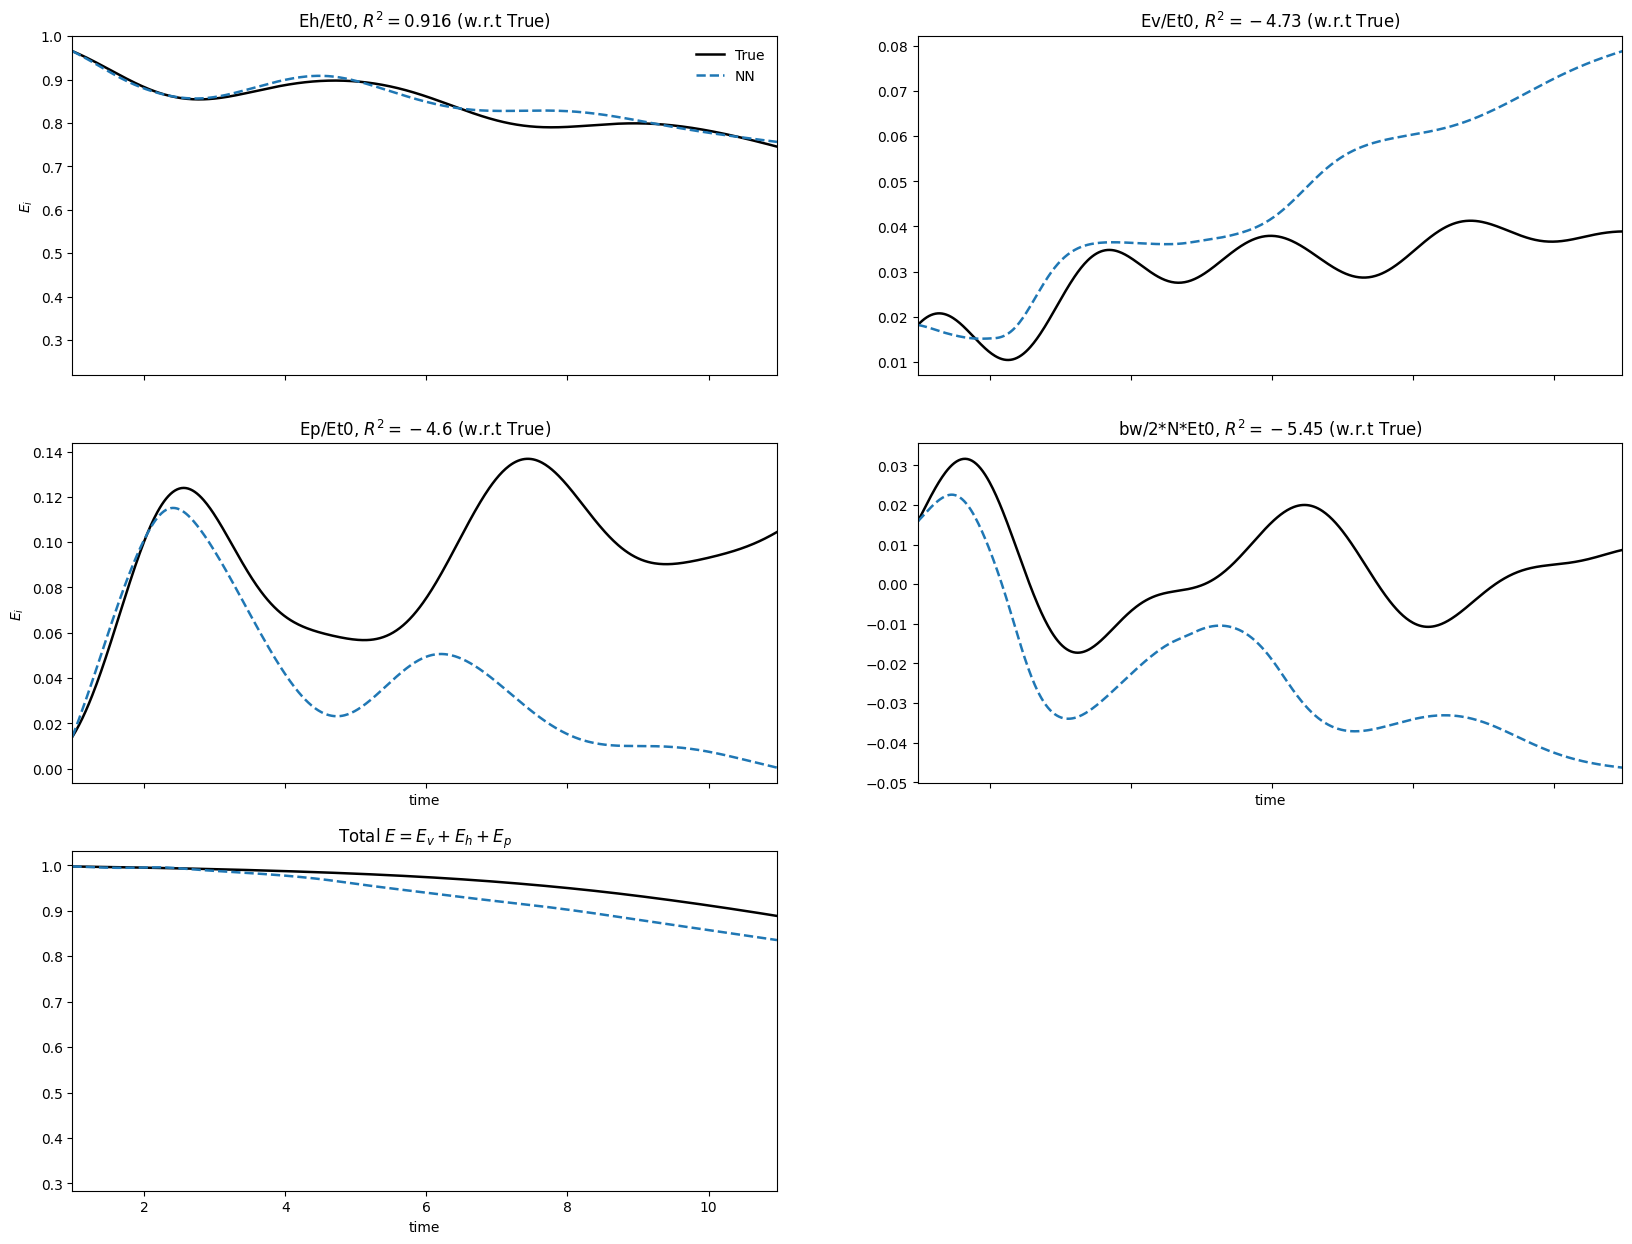

In [9]:
data_op_varnames = [var[2:-4] for var in data_op_varnames]

# plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3,2,figsize=(20,15),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(n_outputs):
    axs[i].plot(test_time,E_true[:,-1,i],'-', color='black', linewidth=1.8, label='True')
    # axs[i].plot(t,q_true[:,i],'--', color='tab:red', label='using true RHS')
    axs[i].plot(t,q_ML[:,i],'--', color='tab:blue', linewidth=1.8, label='NN')
    tempID = [t[:]<test_time[-1]][0]
    r2 = metrics.r2_score(q_true[tempID,i], q_ML[tempID,i])
    axs[i].set_title(f'{data_op_varnames[i]}, $R^2 = {r2:0.3}$ (w.r.t True)')
    axs[i].set_xlim([t[0], t[-1]])
    # axs[i].set_xlim([t[0], 17])
axs[2].set_xlabel(r'time'); axs[3].set_xlabel(r'time')
axs[0].set_ylabel(r'$E_i$')
axs[2].set_ylabel(r'$E_i$')
axs[0].legend(frameon=False);

totalE = np.sum(E_true[:,-1,0:3], axis=1)
totalE_qtrue = np.sum(q_true[:,0:3], axis=1)
axs[4].plot(test_time, totalE, '-', color='black', linewidth=1.8, label='True')
# axs[4].plot(t, totalE_qtrue, '--', color='tab:red', linewidth=1.8, label='using true RHS')
totalE_ML = np.sum(q_ML[:,0:3], axis=1)
axs[4].plot(t, totalE_ML, '--', color='tab:blue', linewidth=1.8, label='NN')
axs[4].set_xlabel(r'time')
axs[4].set_title(r'Total $E = E_v + E_h + E_p$');
axs[-1].axis('off')

if saveFig: plt.savefig(fnameFig, bbox_inches='tight') #,dpi=100)

if saveData:
    np.savez(fnameData,
             test_time=test_time, q_true=E_true[:,-1,:],
             t=t, q_ODE=q_true, q_ML=q_ML, totalEt0 = totalEt0, Nfreq=Nfreq,
             data_op_varnames=data_op_varnames)